# Time Series Forecasting with LSTM Networks

Time series can be used to model many phenomena in economics, science, nature, etc. The main contribution of this paper is to present different LSTM network models that can be applied on this task.

Specifically, in the paper we will explore these particular models:

1. Baseline (persistence model)
2. One-forward LSTM model
3. Sliding window LSTM model
4. Seq2seq LSTM model
5. N-forward LSTM model
6. LSTMGAN  // MAYBE

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CuDNNLSTM, Dropout
import time

In [3]:
# constants used in pre-processing

TEMP_MEAN = 0
TEMP_STD = 0

PRESS_MEAN = 0
PRESS_STD = 0
PRESS_DEFAULT = 1000

HUMIDITY_MEAN = 0
HUMIDITY_STD = 0
HUMIDITY_DEFAULT = 0.5

TIME_ZERO = pd.Timestamp('1970-01-01 00:00:00')
TIME_DELTA = '1h'

SEQ_LENGTH = 48
TO_PREDICT = 24
PERIOD_TO_PREDICT = 24

In [4]:
 # functions for cleaning the data

def preprocess_data(data, val_pct=0.2, to_predict=1):
    
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    
    pct = data.index[-(int(val_pct * len(data)))]
    
    print("pct:", pct, "data.index[0]:", data.index[0], "data.index[-1]:", data.index[-1], "len(data):", len(data))
    
    prev_days_x = deque(maxlen=SEQ_LENGTH)
    prev_days_y = deque(maxlen=to_predict)
    
    for index, row in zip(data.index, data.values):
        if index > data.index[-2 * to_predict]:
            break
        prev_days_x.append([])
        prev_days_y.append([])
        if to_predict == 1: 
            for n in range(len(row)):
                if (n < len(row) / 2):
                    if type(row[n]) is not tuple:
                        prev_days_x[len(prev_days_x) - 1].append(row[n])
    #                 else:
    #                     prev_days_x[len(prev_days_x) - 1].extend(row[n])
                else:
                    if type(row[n]) is not tuple:
                        prev_days_y[len(prev_days_y) - 1].append(row[n])
    #                 else:
    #                     prev_days_y[len(prev_days_y) - 1].extend(row[n])
                
            if len(prev_days_x) == SEQ_LENGTH:
    #             if (rand.rand() < val_pct) TODO! RANDOM SPLIT
                if index < pct:
                    train_x.append(np.array(prev_days_x))
                    train_y.append(np.array(prev_days_y[-1]))
                else:
                    val_x.append(np.array(prev_days_x))
                    val_y.append(np.array(prev_days_y[-1]))
                
        elif to_predict > 1:
            for n in range(len(row)):
                if (n < len(row) / 2):
                    if type(row[n]) is not tuple:
                        prev_days_x[len(prev_days_x) - 1].append(row[n])
                else:
                    if type(row[n]) is not tuple:
                        prev_days_y[len(prev_days_y) - 1].append(row[n])
                
            if len(prev_days_x) == SEQ_LENGTH:
                if index < pct:
                    train_x.append(np.array(prev_days_x))
                    train_y.append(np.array(prev_days_y))
                else:
                    val_x.append(np.array(prev_days_x))
                    val_y.append(np.array(prev_days_y))
    
    # shuffling the data
#     rng_state = np.random.get_state()
#     np.random.shuffle(train_x)
#     np.random.set_state(rng_state)
#     np.random.shuffle(train_y)
        
    return (np.array(train_x), np.array(train_y)), (np.array(val_x), np.array(val_y))


def get_labels(data):
    """ returns the list of distinct labels in given data column """
    labels = list(set(data))
    return labels
    

def data_to_dicts(labels):
    """ returns pair of data to one-hot and one-hot to data dictionaries """
    data_to_oh = {x:tuple(1 if y == labels.index(x) else 0 
                    for y in range(len(labels))) 
                    for x in labels}
    
    oh_to_data = {y:x for x, y in data_to_oh.items()}
    
    return data_to_oh, oh_to_data


# ======= temp =======

def normalize_temp(temp):
    global TEMP_MEAN, TEMP_STD
    TEMP_MEAN = temp.mean()
    TEMP_STD = temp.std()
    return [(t - TEMP_MEAN) / TEMP_STD for t in temp]


def denormalize_temp(temp):
    return [t * TEMP_STD + TEMP_MEAN for t in temp]


def denormalize_temp_single(temp):
    return temp * TEMP_STD + TEMP_MEAN


# ======= press =======

def normalize_press(press):
    global PRESS_MEAN, PRESS_STD
    # 0's mess up mean and std calculations
    press = press.replace(0, PRESS_DEFAULT)
    PRESS_MEAN = press.mean()
    PRESS_STD = press.std()
    return [(p - PRESS_MEAN) / PRESS_STD for p in press]


def denormalize_press(press):
    return [p * PRESS_STD + PRESS_MEAN for p in press]


def denormalize_press_single(press):
    return press * PRESS_STD + PRESS_MEAN


# ======= hum =======

def normalize_humidity(hum):
    global HUMIDITY_MEAN, HUMIDITY_STD
    hum = hum.replace(0, HUMIDITY_DEFAULT)
    HUMIDITY_MEAN = hum.mean()
    HUMIDITY_STD = hum.std()
    return [(h - HUMIDITY_MEAN) / HUMIDITY_STD for h in hum]


def denormalize_humidity(hum):
    return [h * HUMIDITY_STD + HUMIDITY_MEAN for h in hum]


def denormalize_humidity_single(hum):
    return hum * HUMIDITY_STD + HUMIDITY_MEAN

# ===================

def normalize_time(times):
    """ converts date-time data column to a UNIX-style int (number of TIME_DELTA steps since TIME_ZERO) """
    times = [pd.Timestamp(time[:-6]) for time in times]
    times = [((time - TIME_ZERO) // pd.Timedelta(TIME_DELTA)) for time in times]
    return times


# def denormalize_time(time):
# TODO


def one_hot_encode(data, data_to_oh):
    return [data_to_oh[d] for d in data]


def one_hot_decode(oh, oh_to_data):
    return [oh_to_data[o] for o in oh]

In [5]:
df = pd.read_csv("weatherHistory.csv", names = ['time', 'summary', 'precip', 'temp', 'app_temp', 'humidity', 'wind_speed', 'wind_bearing', 'visibility', 'loud_cover', 'pressure', 'daily_summary'], low_memory=False)

df = df.drop([0])
df = df.drop(['app_temp', 'wind_speed', 'wind_bearing', 'visibility', 'loud_cover', 'daily_summary'], axis=1) # TODO add wind_speed and other usefull data

df = df.drop(['summary', 'precip'], axis=1)

df.set_index('time', inplace=True)
df.index = normalize_time(df.index)

df = df.astype('float32')
print(df.columns.values)

['temp' 'humidity' 'pressure']


In [6]:
# summary_labels = get_labels(df['summary'])
# print("len(summary_labels):", len(summary_labels))

# our training data contains nans when there is no precipitation
# df['precip'] = df['precip'].fillna("clear")
# precip_labels = get_labels(df['precip'])
# print("len(precip_labels):", len(precip_labels))

# daily_summary_labels = get_labels(df['daily_summary'])
# print("len(daily_summary_labels):", len(daily_summary_labels))


# summary_to_oh, oh_to_summary = data_to_dicts(summary_labels)
# precip_to_oh, oh_to_precip = data_to_dicts(precip_labels)

# print(summary_to_oh, oh_to_summary, sep='\n\n')
# print(precip_to_oh, oh_to_precip, sep='\n\n')

# df['summary'] = one_hot_encode(df['summary'], summary_to_oh)
# df['summary'].head()
# df['precip'] = one_hot_encode(df['precip'], precip_to_oh)
# df['precip'].head()

In [7]:
df['temp'] = normalize_temp(df['temp'])
df['pressure'] = normalize_press(df['pressure'])
df['humidity'] = normalize_humidity(df['humidity'])
# df['humidity'] = df['humidity'].apply(pd.to_numeric)

print("temperature: mean={}, std={}".format(TEMP_MEAN, TEMP_STD))
print("pressure: mean={}, std={}".format(PRESS_MEAN, PRESS_STD))
print("humidity: mean={}, std={}".format(HUMIDITY_MEAN, HUMIDITY_STD))

# print(denormalize_temp(df['temp'])[:5])
# print(denormalize_press(df['pressure'])[:5])
# print(min(df['temp']), max(df['temp']), '\n', min(df['pressure']), max(df['pressure']))

temperature: mean=11.93267822265625, std=9.551546096801758
pressure: mean=1016.5895385742188, std=7.963654041290283
humidity: mean=0.735012948513031, std=0.19518959522247314


In [8]:
# sorting data by index
df = df.sort_index()

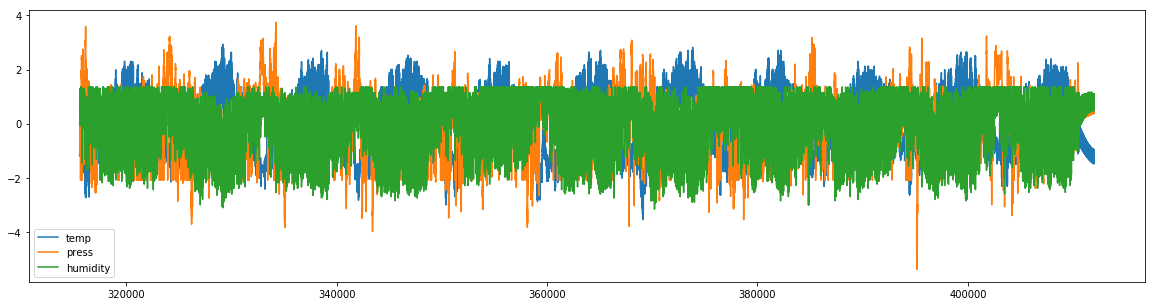

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(df['temp'], label="temp")
plt.plot(df['pressure'], label="press")
plt.plot(df['humidity'], label="humidity")
plt.legend()
plt.show()

In [10]:
# we shift values so that each row has a corresponding future row
for col in df.columns:
    df["future_{}".format(col)] = df["{}".format(col)].shift(-PERIOD_TO_PREDICT)

In [11]:
df.head()

,temp,humidity,pressure,future_temp,future_humidity,future_pressure
315576,-1.188802,0.794033,0.008845,-0.681613,0.640337,-0.877683
315577,-1.127730,0.589105,-0.055190,-1.003259,0.896498,-0.234763
315578,-1.074801,0.435408,-0.090353,-0.681613,0.332943,-0.940468
315579,-1.070148,0.435408,-0.129280,-0.631010,0.332943,-0.964327
315580,-1.125404,0.640337,-0.202113,-0.624612,0.332943,-1.013294


In [12]:
%%time
df = df.loc[:410500];
(train_x, train_y), (val_x, val_y) = preprocess_data(df, 0.3, PERIOD_TO_PREDICT)

print("shape of train x:", train_x.shape)
print("shape of train y:", train_y.shape)
print("shape of val x:", val_x.shape)
print("shape of val y:", val_y.shape)
print("ratio:", len(val_x) / (len(train_x) + len(val_x)))

pct: 382016 data.index[0]: 315576 data.index[-1]: 410500 len(data): 94946
shape of train x: (66416, 48, 3)
shape of train y: (66416, 24, 3)
shape of val x: (28436, 48, 3)
shape of val y: (28436, 24, 3)
ratio: 0.2997933622907266
Wall time: 4.23 s


# Models

In [11]:
TEST_SIZE = 1000

### 1. Baseline (persistence model)
The persistence model is a very simple method usually only used to compare results of other approaches. This method is not usable in real-life scenarios. Given n data points as input, the method simply predicts the last data point. Obviously, this will produce a constant value if it's asked to predict more than one data points.

In [12]:
def persistence_bl(data):
    return np.array([d[-1] for d in data])

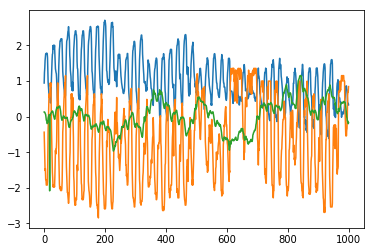

In [13]:
predictions_bl = persistence_bl(val_x[:TEST_SIZE])
plt.plot(predictions_bl)
plt.show()

As it can be observed from the graph all the values are shifted by one.

### 2. One-forward LSTM model

Given n consecutive data points, this model predicts (n+1)th data point. This model has limited applications in real life tasks, since any predictions made by the model are replaced by real data in subsequent predictions, effectively ignoring errors.

In [65]:
# this function trains and returns a basic one-forward LSTM that can be used in several subsequent models.
def one_forward_model():
    # constants used in the model

    LSTM_LAYERS = 1
    LSTM_UNITS = 256

    FC_LAYERS = 1
    FC_UNITS = 64
    
    # INPUT_DIM = (len(summary_labels) + len(precip_labels) + 3) * SEQ_LENGTH
    INPUT_DIM = 3 * SEQ_LENGTH
    # OUTPUT_DIM = 3 * SEQ_LENGTH
    OUTPUT_DIM = 3

    BATCH_SIZE = 256
    
    
    # NAME = "weather_forecaster_{}".format(int(time.time()))
    # tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
#     print(f"Configuration: lstm layers: {lstm_l}, lstm units: {lstm_u}, fc layers: {fc_l}, fc units: {fc_u}")
    model = Sequential()

#                     for i in range(LSTM_LAYERS):
    for i in range(LSTM_LAYERS):
        if i == 0:
            if i != LSTM_LAYERS - 1:
                model.add(CuDNNLSTM(LSTM_UNITS, input_shape=(train_x.shape[1:]), return_sequences=True))
            else:
                model.add(CuDNNLSTM(LSTM_UNITS, input_shape=(train_x.shape[1:]), return_sequences=False))
        else:
            if i != LSTM_LAYERS - 1:
                model.add(CuDNNLSTM(LSTM_UNITS, return_sequences=True))
            else:
                model.add(CuDNNLSTM(LSTM_UNITS, return_sequences=False))
        model.add(Dropout(0.5))
    for i in range(FC_LAYERS):
        model.add(Dense(FC_UNITS, activation='tanh'))

    model.add(Dense(OUTPUT_DIM, activation='linear'))
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
    model.fit(train_x, train_y, epochs=10, batch_size=BATCH_SIZE, validation_data=(val_x, val_y), verbose=1)
#     print(model.evaluate(val_x, val_y))
                    
                    
    return model

In [66]:
models = one_forward_model()

Train on 66416 samples, validate on 28482 samples
Epoch 1/10


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\imran\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\client\session.py", line 1292, in _do_call
    return fn(*args)
  File "c:\users\imran\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\client\session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "c:\users\imran\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\client\session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.InternalError: GPU sync failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\imran\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-de098370d6e7>", line 1, in <module>


TypeError: must be str, not list

In [41]:
for i in range(len(models)):
    plt.subplot(len(models) // 2, 2, i)
    predictions_sw = sliding_w(val_x[:TEST_SIZE + TEST_SIZE // 5], models[i])
    predictions_sw = predictions_sw[:TEST_SIZE]
    plt.plot(predictions_sw)
plt.show()

In [15]:
def one_forward(data, model_of=None):
    if model_of is None:
        model_of = one_forward_model()
    
    return model_of.predict(data)

In [36]:
model_of = one_forward_model()

Train on 66416 samples, validate on 28482 samples
Epoch 1/25
66416/66416 [==============================] - 9s 130us/step - loss: 0.2401 - acc: 0.8654 - val_loss: 0.1336 - val_acc: 0.9151
Epoch 2/25
66416/66416 [==============================] - 7s 111us/step - loss: 0.1829 - acc: 0.9001 - val_loss: 0.1209 - val_acc: 0.9216
Epoch 3/25
66416/66416 [==============================] - 7s 111us/step - loss: 0.1770 - acc: 0.9017 - val_loss: 0.1201 - val_acc: 0.9227
Epoch 4/25
66416/66416 [==============================] - 7s 111us/step - loss: 0.1746 - acc: 0.9029 - val_loss: 0.1162 - val_acc: 0.9219
Epoch 5/25
66416/66416 [==============================] - 7s 109us/step - loss: 0.1718 - acc: 0.9030 - val_loss: 0.1142 - val_acc: 0.9243
Epoch 6/25
66416/66416 [==============================] - 6s 98us/step - loss: 0.1695 - acc: 0.9033 - val_loss: 0.1165 - val_acc: 0.9216
Epoch 7/25
66416/66416 [==============================] - 7s 98us/step - loss: 0.1682 - acc: 0.9040 - val_loss: 0.1122 - va

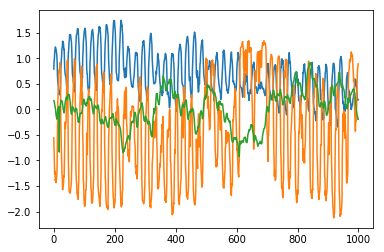

In [37]:
predictions_of = one_forward(val_x[:TEST_SIZE], model_of)
plt.plot(predictions_of)
plt.show()

### 3. Sliding window LSTM model

Given n consecutive data points, this model predicts k consecutive points, using its own previous predictions as input data in following steps. The method uses the same LSTM model as the one-forward method. The input data is replaced by real data whenever k of its data points consist of previous predictions. This model is usable in real tasks, since it does not depend on continuous flow of fresh real data, and predicts all k data points using only initial n points.

In [18]:
def append_to_end(x, val):
    for i in range(len(x) - 1):
        x[i] = x[i + 1]
    x[-1] = val

In [19]:
def sliding_w(data, model_of=None):
    if model_of is None:
        model_of = one_forward_model()
        
    output = []
    
    for i in range(len(data) // TO_PREDICT):
        x = np.copy(data[i * TO_PREDICT])
        for j in range(TO_PREDICT):
            output.append(model_of.predict(x.reshape(-1, 48, 3)).reshape(3,))
            append_to_end(x, output[-1])
    return np.array(output)

In [ ]:
predictions_sw = sliding_w(val_x[:TEST_SIZE + TEST_SIZE // 5], model_of)
predictions_sw = predictions_sw[:TEST_SIZE]
plt.plot(predictions_sw)
plt.show()

### 6. LSTM GAN

A novel method 

Training started!
Epoch 1 completed out of 15 loss: 0.38197732
Epoch 2 completed out of 15 loss: 0.3483867
Epoch 3 completed out of 15 loss: 0.34085754
Epoch 4 completed out of 15 loss: 0.33470342
Epoch 5 completed out of 15 loss: 0.3258068
Epoch 6 completed out of 15 loss: 0.32189733
Epoch 7 completed out of 15 loss: 0.3507392
Epoch 8 completed out of 15 loss: 0.35278055
Epoch 9 completed out of 15 loss: 0.3470281
Epoch 10 completed out of 15 loss: 0.31278014
Epoch 11 completed out of 15 loss: 0.3120643
Epoch 12 completed out of 15 loss: 0.30356157
Epoch 13 completed out of 15 loss: 0.30229148
Epoch 14 completed out of 15 loss: 0.30610657
Epoch 15 completed out of 15 loss: 0.30681482
Training done!
(50, 48, 3)
(300, 3)


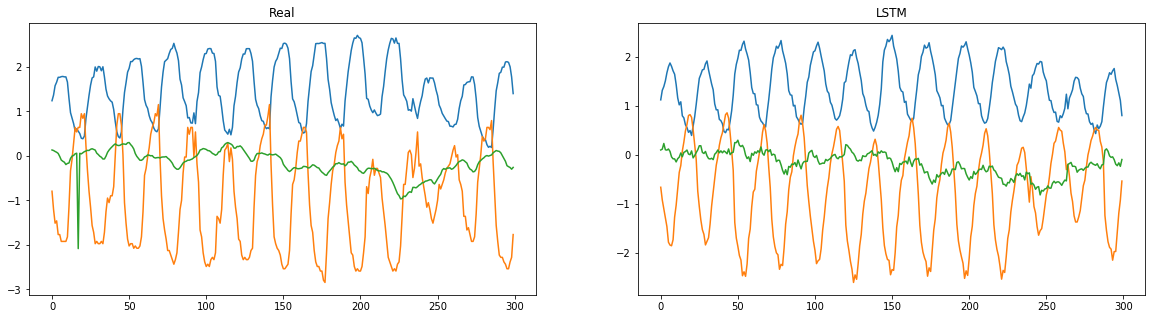

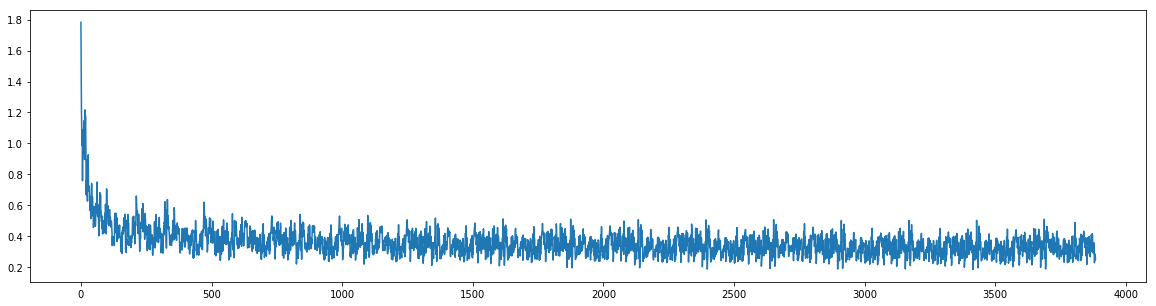

In [29]:
import time
import tensorflow as tf

tf.reset_default_graph()

def LSTM(): # Returns tf model
    
    LSTM_UNITS = 256

    FC_UNITS = 64

    INPUT_DIM = 3
    OUTPUT_DIM = 3

    BATCH_SIZE = 256
    
    x = tf.placeholder(tf.float32, [None, SEQ_LENGTH, INPUT_DIM], name="x")
    y = tf.placeholder(tf.float32, [None, PERIOD_TO_PREDICT, OUTPUT_DIM], name="y")
    
    def predict(x): # Returns a prediction

        weights = tf.Variable(tf.random_normal([LSTM_UNITS, OUTPUT_DIM * PERIOD_TO_PREDICT]), name="fc_weights")
        biases = tf.Variable(tf.random_normal([OUTPUT_DIM * PERIOD_TO_PREDICT]), name="fc_biases")

        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, [-1, INPUT_DIM])
        x = tf.split(x, SEQ_LENGTH, 0)

        lstm_cell = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS, state_is_tuple=True, name="LSTM_cell")
        outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

        output = tf.matmul(tf.nn.tanh(outputs[-1]), weights) + biases
        
        return tf.reshape(output, [-1, PERIOD_TO_PREDICT, OUTPUT_DIM])
    
    prediction = predict(x)
    cost = tf.reduce_mean(tf.abs(prediction - y))
    optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        c = sess.run(cost, feed_dict={x: val_x, y: val_y})
        print("Training started!")
        
        EPOCHS = 15
        
        losses = []
        
        for epoch in range(EPOCHS):
            for i in range(len(train_x) // BATCH_SIZE):
                epoch_x = train_x[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
                epoch_y = train_y[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                
                losses.append(c)

            c = sess.run(cost, feed_dict={x: val_x, y: val_y})
            print('Epoch', epoch + 1, 'completed out of', EPOCHS, 'loss:', c)
        print("Training done!")
        
        TEST_PRED = 300
        
#         predictions_lstm = sess.run(prediction, feed_dict={x: val_x[:1000]})
#         predictions_lstm = sess.run(prediction, feed_dict={x: np.array([val_x[i] for i in range(0, 1200, 24)])})
        predictions_lstm = sess.run(prediction, feed_dict={x: np.array([val_x[i] for i in range(0, 1200, 24)])})
        predictions_lstm = np.reshape(predictions_lstm, [-1, 3])
        predictions_lstm = predictions_lstm[:TEST_PRED]
        
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 2, 1)
        real = np.array([val_y[i] for i in range(0, 1200, 24)])
        real = np.reshape(real, [-1, 3])
        plt.plot(real[:TEST_PRED])
        plt.title("Real")
        
        plt.subplot(1, 2, 2)
        plt.plot(predictions_lstm)
        plt.title("LSTM")
        plt.show()
        
        plt.figure(figsize=(20, 5))
        plt.plot(losses)
        plt.show()
        
        
LSTM()

## Results

Here you can see graphs and error values for all of mentioned models tested on the same subset of the evaluation set.

NameError: name 'TEST_SIZE' is not defined

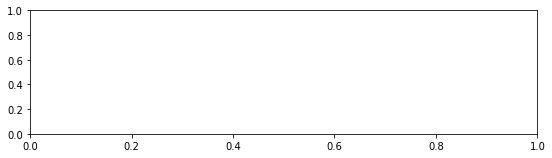

In [14]:
plt.figure(figsize=(20, 5))

plt.subplot(2, 2, 1)
plt.plot(val_y[:TEST_SIZE])
plt.title("Real")

plt.subplot(2, 2, 2)
plt.plot(predictions_bl[:TEST_SIZE])
plt.title("Persistence")

plt.subplot(2, 2, 3)
plt.plot(predictions_of[:TEST_SIZE])
plt.title("One-forward")

plt.subplot(2, 2, 4)
plt.plot(predictions_sw[:TEST_SIZE])
plt.title("Sliding window")

plt.show()

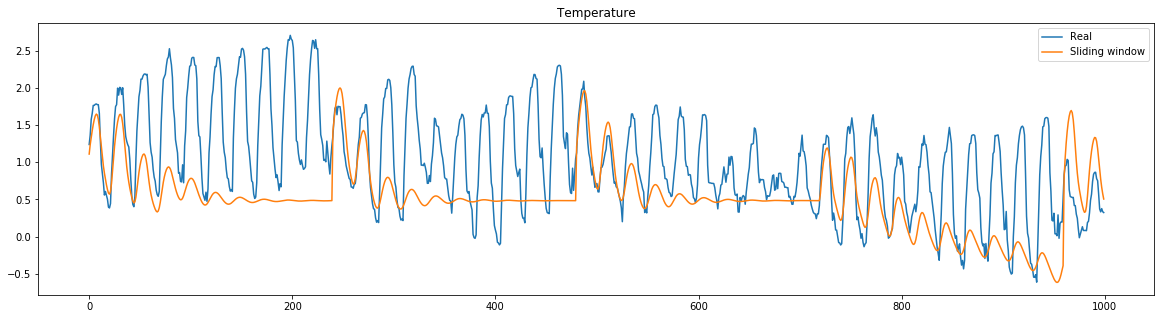

In [30]:
plt.figure(figsize=(20, 5))

plt.title("Temperature")
plt.plot([val_y[i][0] for i in range(TEST_SIZE)]         , linewidth=1.5, label="Real")
# plt.plot([predictions_bl[i][0] for i in range(TEST_SIZE)], linewidth=1.5, label="Persistence")
# plt.plot([predictions_of[i][0] for i in range(TEST_SIZE)], linewidth=1.5, label="One-forward")
plt.plot([predictions_sw[i][0] for i in range(TEST_SIZE)], linewidth=1.5, label="Sliding window")

plt.legend()
plt.show()

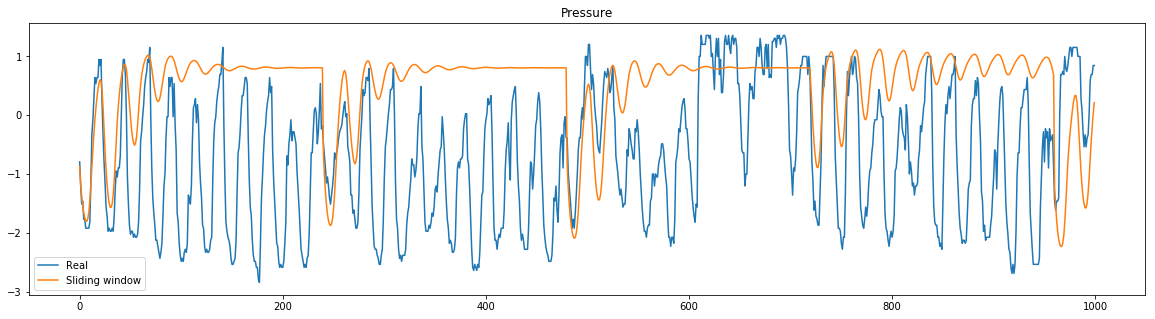

In [32]:
plt.figure(figsize=(20, 5))

plt.title("Pressure")
plt.plot([val_y[i][1] for i in range(TEST_SIZE)]         , linewidth=1.5, label="Real")
# plt.plot([predictions_bl[i][1] for i in range(TEST_SIZE)], linewidth=1.5, label="Persistence")
# plt.plot([predictions_of[i][1] for i in range(TEST_SIZE)], linewidth=1.5, label="One-forward")
plt.plot([predictions_sw[i][1] for i in range(TEST_SIZE)], linewidth=1.5, label="Sliding window")

plt.legend()
plt.show()

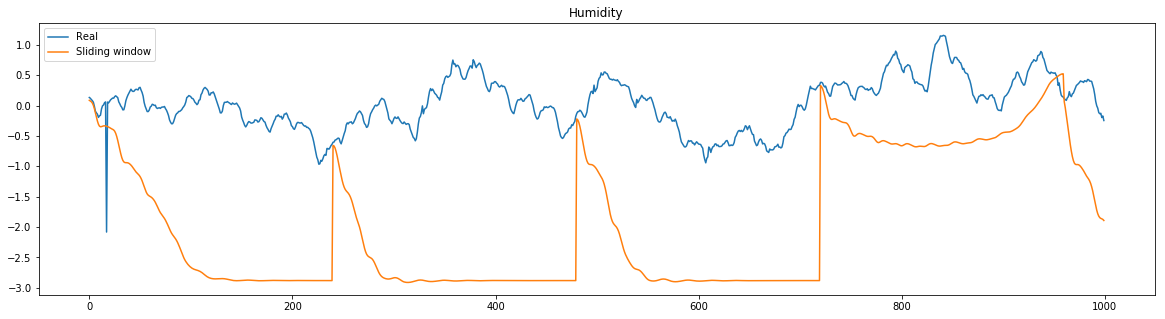

In [31]:
plt.figure(figsize=(20, 5))

plt.title("Humidity")
plt.plot([val_y[i][2] for i in range(TEST_SIZE)]         , linewidth=1.5, label="Real")
# plt.plot([predictions_bl[i][2] for i in range(TEST_SIZE)], linewidth=1.5, label="Persistence")
# plt.plot([predictions_of[i][2] for i in range(TEST_SIZE)], linewidth=1.5, label="One-forward")
plt.plot([predictions_sw[i][2] for i in range(TEST_SIZE)], linewidth=1.5, label="Sliding window")

plt.legend()
plt.show()

In [25]:
# print(val_y.shape)
real_temp = []
output_temp1 = []
output_temp2 = []

temp_size = 24*7

# for val in val_y[:400]:
#     real_temp.append(val[0] * TEMP_COEF)
    
# for val in output1[:400]:
#     output_temp1.append(val[0] * TEMP_COEF)
    
# for val in output2[:400]:
#     output_temp2.append(val[0] * TEMP_COEF)


for val in val_y[:temp_size]:
    real_temp.append(denormalize_temp_single(val[0]))
    
for val in output1[:temp_size]:
    output_temp1.append(denormalize_temp_single(val[0]))
    
for val in output2[:temp_size]:
    output_temp2.append(denormalize_temp_single(val[0]))


plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(real_temp)
plt.title("Real")

plt.subplot(1, 3, 2)
plt.plot(output_temp1)
plt.title("Soxuw")

plt.subplot(1, 3, 3)
plt.plot(output_temp2)
plt.title("Sliding")

plt.suptitle("Temperature", fontsize=18)
plt.show()

NameError: name 'output1' is not defined

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot(real_temp, label="Real")

plt.plot(output_temp1, label="Soxuw")

plt.plot(output_temp2, label="Sliding")

plt.title("Temperature")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# hm_epochs = 1
# rnn_size = 128

# tf.reset_default_graph()

# x = tf.placeholder(tf.float32, [None, SEQ_LENGTH, num_features])
# y = tf.placeholder(tf.float32, [None, num_features])

# def recurrent_neural_network(x):
#     layer = {'weights':tf.Variable(tf.random_normal([rnn_size, num_features])),
#              'biases':tf.Variable(tf.random_normal([num_features]))}

#     x = tf.transpose(x, [1, 0, 2])
#     x = tf.reshape(x, [-1, num_features])
#     x = tf.split(x, SEQ_LENGTH, 0)

#     lstm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size, state_is_tuple=True)
#     outputs, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

#     output = tf.matmul(outputs[-1], layer['weights']) + layer['biases']

#     return output


# def train_neural_network(x):
#     prediction = recurrent_neural_network(x)
#     cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y) )
#     optimizer = tf.train.AdamOptimizer().minimize(cost)
    
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())

#         for epoch in range(hm_epochs):
#             epoch_loss = 0
# #             for _ in range(int(mnist.train.num_examples/batch_size)):
#             for i in range(int(len(train_x)/batch_size)):
# #                 epoch_x, epoch_y = mnist.train.next_batch(batch_size)
#                 epoch_x = train_x[i * batch_size:(i + 1) * batch_size]
#                 epoch_y = train_y[i * batch_size:(i + 1) * batch_size]
# #                 epoch_x = epoch_x.reshape((batch_size,n_chunks,chunk_size))

#                 _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
#                 epoch_loss += c

#             print('Epoch', epoch + 1, 'completed out of', hm_epochs,'loss:', epoch_loss)

# #         correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

# #         accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
#         accuracy, _ = tf.metrics.mean_squared_error(labels=y, predictions=prediction)
# #         print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
# #         print('Accuracy:',accuracy.eval({x:val_x, y:val_y}))
#         print('Accuracy:', sess.run(accuracy, feed_dict={x: val_x, y: val_y}))

# train_neural_network(x)